# Introduction to Monte Carlo Simulation

The following notebook contains the code behind my Introduction to Monte Carlo Simulation tutorial.

## Imports

In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.ticker as ticker
import urllib3

from random import randint
from statistics import mode
from PIL import Image

from tabulate import tabulate

## Fonts & Stylesheets

In [2]:
plt.style.use("../assets/stylesheets/soc_base.mplstyle")
main_path = "../assets/fonts/"

for x in os.listdir(main_path):
    for y in os.listdir(f"{main_path}/{x}"):
        if y.split(".")[-1] == "ttf":
            fm.fontManager.addfont(f"{main_path}/{x}/{y}")
            try:
                fm.FontProperties(weight=y.split("-")[-1].split(".")[0].lower(), fname=y)
            except Exception as e:
                continue

## The Dice Game

Let's define a function that simulates the throw of ten dice, and then computes the sum of the results.

In [3]:
def throw_and_sum_n_dice(n):
    '''
    This function throws n dice and sums the results
    '''
    total = 0
    for i in range(0,n):
        throw = randint(1,6)
        total += throw
    return total

In [4]:
print(f'The sum of the dice is: {throw_and_sum_n_dice(10)}')

The sum of the dice is: 34


Call the function a million times to check how often we would've won some money.

In [5]:
iterations = 1000000
winning_occurances = 0
for i in range(iterations):
    total = throw_and_sum_n_dice(10)
    if total >= 40 and total <= 50:
        winning_occurances += 1

print(f'We would\'ve won money {winning_occurances:,.0f} times -- a.k.a. {winning_occurances/iterations:.3%} of the time.') 

We would've won money 203,025 times -- a.k.a. 20.303% of the time.


Let's imagine that we now play the game fifty times and at the end we distribute the payouts.

In [6]:
def compute_profit_path(k, n):
    '''
    This function returns the porfit (or loss) path at the end of 
    k iterations of the game, and where we throw n dice.
    '''
    total_profit = 0
    for i in range(k):
        total = throw_and_sum_n_dice(n)
        if total >= 40 and total <= 50:
            total_profit += 10
        else:
            total_profit += -2
    return total_profit

In [7]:
winnings = compute_profit_path(50,10)
print(f'On a sinlge simulation of the game 50 times we would {"win" if winnings > 0 else "lose"} {winnings} dollars')

On a sinlge simulation of the game 50 times we would win 68 dollars


Finally, let's perform a Monte Carlo simulation on the paths to see if we should play this game.

However, let's reduce the number of simulations to 100,000.

In [8]:
iterations = 100000
total_profits = []
for i in range(iterations):
    total_profits.append(compute_profit_path(50,10))

Let's describe the results

In [9]:
print(f'We would win some money {sum([1 for x in total_profits if x > 0])/iterations:.1%} of the time.')
print(f'Our simulation estimated that the maximum amount we could win is {max(total_profits)} dollars.')
print(f'Our simulation estimated that the maximum amount we could lose is {abs(min(total_profits))} dollars.')
most_common = mode(total_profits)
print(f'The most common outcome is that we win {most_common} dollars; which happens {sum([1 for x in total_profits if x == most_common])/iterations:.1%} of the time.')
print(f'We would win more than 10 dollars in {sum([1 for x in total_profits if x > 10])/iterations:.1%} of scenarios')
print(f'We would lose more than 10 dollars in {sum([1 for x in total_profits if x < -10])/iterations:.1%} of scenarios')

We would win some money 71.4% of the time.
Our simulation estimated that the maximum amount we could win is 188 dollars.
Our simulation estimated that the maximum amount we could lose is 88 dollars.
The most common outcome is that we win 20 dollars; which happens 14.0% of the time.
We would win more than 10 dollars in 57.9% of scenarios
We would lose more than 10 dollars in 17.5% of scenarios


And visualize them in a histogram

In [10]:
profit_df = pd.DataFrame({'total_profit':total_profits})
profit_df['bin'] = pd.cut(profit_df['total_profit'], bins=[x for x in range(-90, 171, 15)])
profit_df = profit_df.groupby(['bin']).count().reset_index()
profit_df['share'] = profit_df['total_profit']/iterations

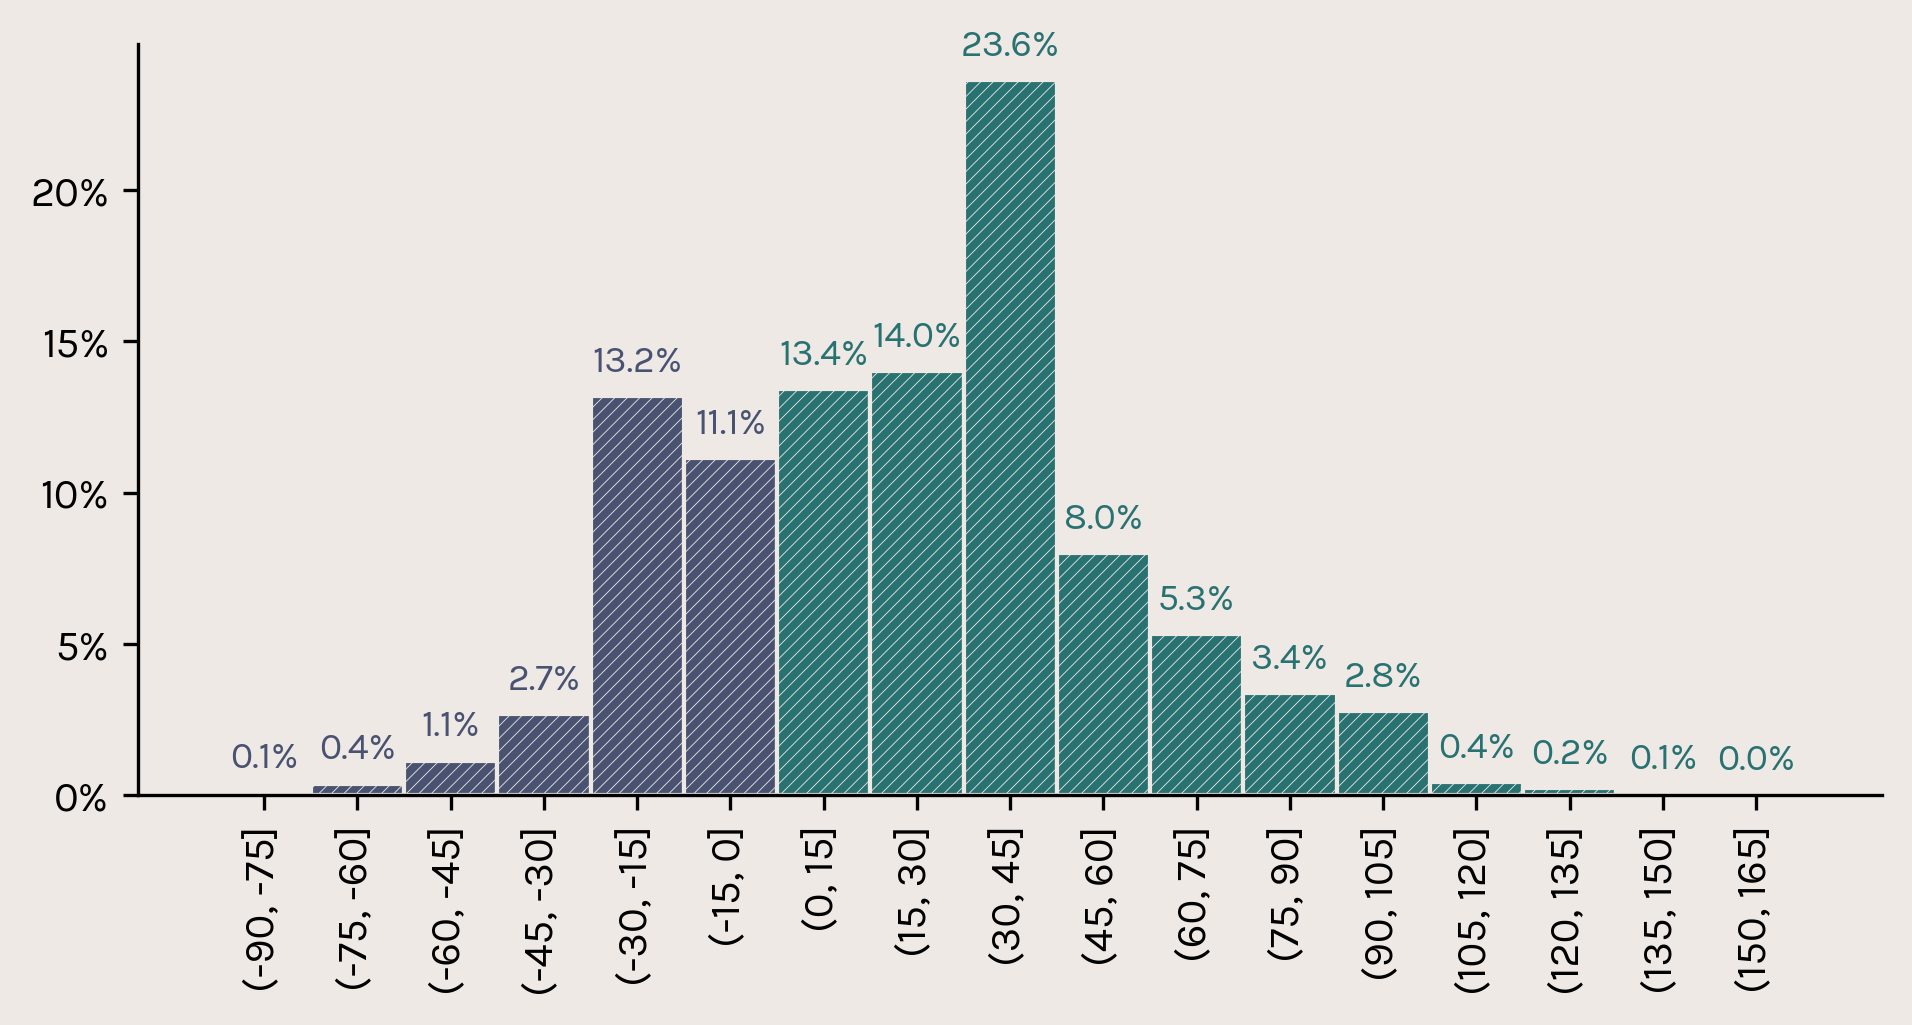

In [11]:
fig = plt.figure(dpi=300)
ax = plt.subplot()
plt.rcParams['hatch.linewidth'] = 0.2

bars_ = ax.bar(profit_df.index, profit_df['share'], hatch='////////', ec=ax.get_facecolor(), width=1)
for index, b in enumerate(bars_):
    if profit_df['bin'].iloc[index].left < 0:
        color = '#495371'
    else:
        color = '#287271'
    b.set_facecolor(color)
    ax.annotate(
        xy=(index, b.get_height()), text=f'{b.get_height():.1%}',
        xytext=(0,8), textcoords='offset points', 
        ha='center', va='center',
        color=color, size=9
    )

ticks = ax.set_xticks(
    ticks=profit_df.index,
    labels=profit_df['bin'],
    rotation=90
)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0%}'))
plt.savefig(
	"figures/dice_game_hist.png",
	dpi = 600,
	facecolor = "none",
	bbox_inches="tight",
    edgecolor="none",
	transparent = True
)

## Applying Monte Carlo to Football data

### Loading the data

The following dataset contains all of the shots taken during the Champions League Group stage.

In [26]:
df = pd.read_csv('data/ucl_shot_data.csv', index_col=0)
# -- We filter own goals since they have no xG
df = df[df['is_own_goal'] == False]
df.head()
# print(tabulate(df.head(), tablefmt='pipe', headers='keys'))

,shot_id,event_type,team_id,player_id,player_name,shot_x,shot_y,min,min_added,is_blocked,...,xGOT,shot_type,situation,period,is_own_goal,on_goal_x,on_goal_y,match_id,short_name,team_name
0,2456730363,Miss,178475,450980,Timo Werner,98.052629,48.134524,3,NaN,False,...,NaN,LeftFoot,FastBreak,FirstHalf,False,0.000000,36.572330,4010151,NaN,RB Leipzig
1,2456736539,AttemptSaved,178475,704523,Christopher Nkunku,90.199997,37.202501,12,NaN,True,...,NaN,RightFoot,FromCorner,FirstHalf,False,27.752976,14.239029,4010151,NaN,RB Leipzig
2,2456736981,AttemptSaved,178475,704523,Christopher Nkunku,97.956139,36.973751,12,NaN,False,...,0.0910,RightFoot,RegularPlay,FirstHalf,False,33.199405,5.695612,4010151,NaN,RB Leipzig
3,2456739727,Goal,9728,620543,Maryan Shved,75.952909,40.805716,16,NaN,False,...,0.5745,LeftFoot,RegularPlay,FirstHalf,False,80.401786,1.873556,4010151,NaN,Shakhtar Donetsk
4,2456747617,Miss,178475,388523,André Silva,81.358738,37.202501,29,NaN,False,...,NaN,RightFoot,RegularPlay,FirstHalf,False,229.772520,24.955772,4010151,NaN,RB Leipzig


In [99]:
match_data = pd.read_csv('data/match_info_data.csv', index_col=0)
match_data.head()
# print(tabulate(match_data.head(), tablefmt='pipe', headers='keys'))

,date,match_id,home_team_id,home_team_name,away_team_id,away_team_name,home_team_score,away_team_score,finished,cancelled,result,league_id,league_name
0,2022-09-07 18:45:00,4010118,8593,Ajax,8548,Rangers,4,0,True,False,Home,42,Champions League
1,2022-09-07 21:00:00,4010119,9875,Napoli,8650,Liverpool,4,1,True,False,Home,42,Champions League
2,2022-09-07 21:00:00,4010138,9906,Atletico Madrid,9773,FC Porto,2,1,True,False,Home,42,Champions League
3,2022-09-07 21:00:00,4010139,8342,Club Brugge,8178,Leverkusen,1,0,True,False,Home,42,Champions League
4,2022-09-07 21:00:00,4010163,8634,Barcelona,6033,Viktoria Plzen,5,1,True,False,Home,42,Champions League


### Simulating a match

In [67]:
def simulate_match_on_shots(match_id, shot_df, home_team_id, away_team_id):
    '''
    This function takes a match ID and simulates an outcome based on the shots
    taken by each team.
    '''

    shots = shot_df[shot_df['match_id'] == match_id]

    shots_home = shots[shots['team_id'] == home_team_id]
    shots_away = shots[shots['team_id'] == away_team_id]

    home_goals = 0
    # If shots == 0 then there's no sampling
    if shots_home['xG'].shape[0] > 0:
        for shot in shots_home['xG']:
            # Sample a number between 0 and 1
            prob = np.random.random()
            # If the probability sampled is less than the xG then it's a goal.
            if prob < shot:
                home_goals += 1
    away_goals = 0
    if shots_away['xG'].shape[0] > 0:
        for shot in shots_away['xG']:
            # Sample a number between 0 and 1
            prob = np.random.random()
            # If the probability sampled is less than the xG then it's a goal.
            if prob < shot:
                away_goals += 1
    return {'home_goals':home_goals, 'away_goals':away_goals}

Let's check to see if it works with the Rangers vs. Ajax fixture.

In [68]:
simulate_match_on_shots(match_id=4010118, shot_df=df, home_team_id=8593, away_team_id=8548)

{'home_goals': 1, 'away_goals': 0}

### Iterating $k$ times

In [69]:
def iterate_k_simulations_on_match_id(match_id, shot_df, match_info, k=10000):
    '''
    Performs k simulations on a match, and returns the probabilites of a win, loss, draw.
    '''
    # Count the number of occurances
    home = 0
    draw = 0
    away = 0
    # Get the teams
    home_team_id = match_info[match_info['match_id'] == match_id]['home_team_id'].iloc[0]
    away_team_id = match_info[match_info['match_id'] == match_id]['away_team_id'].iloc[0]
    for i in range(k):
        simulation = simulate_match_on_shots(match_id, shot_df, home_team_id, away_team_id)
        if simulation['home_goals'] > simulation['away_goals']:
            home += 1
        elif simulation['home_goals'] < simulation['away_goals']:
            away += 1
        else:
            draw += 1
    home_prob = home/k
    draw_prob = draw/k
    away_prob = away/k
    return {'home_prob': home_prob, 'away_prob': away_prob, 'draw_prob': draw_prob, 'match_id': match_id}

In [70]:
iterate_k_simulations_on_match_id(4010118, df, match_data)

{'home_prob': 0.8827,
 'away_prob': 0.0114,
 'draw_prob': 0.1059,
 'match_id': 4010118}

### Performing it across all matches

Now it's time for the good part. Let's simulate across all matches in the UCL.

This might be a good time to get a cup of coffee.

In [71]:
match_probs = []
for index, match in enumerate(match_data['match_id']):
    outcome_probs = iterate_k_simulations_on_match_id(match, df, match_data)
    match_probs.append(outcome_probs)
    if index % 10 == 0:
        print(f'{index/match_data.shape[0]:.1%} done.')

0.0% done.
10.4% done.
20.8% done.
31.2% done.
41.7% done.
52.1% done.
62.5% done.
72.9% done.
83.3% done.
93.8% done.


In [97]:
match_probs_df = pd.DataFrame(match_probs)
# only for sorting :)
match_probs_df = match_probs_df[['match_id', 'home_prob','draw_prob','away_prob']]

### Merging it back

In [98]:
final_df = pd.merge(match_data, match_probs_df, on='match_id')
final_df.head()

,date,match_id,home_team_id,home_team_name,away_team_id,away_team_name,home_team_score,away_team_score,finished,cancelled,result,league_id,league_name,home_prob,draw_prob,away_prob
0,2022-09-07 18:45:00,4010118,8593,Ajax,8548,Rangers,4,0,True,False,Home,42,Champions League,0.8818,0.1065,0.0117
1,2022-09-07 21:00:00,4010119,9875,Napoli,8650,Liverpool,4,1,True,False,Home,42,Champions League,0.9472,0.0377,0.0151
2,2022-09-07 21:00:00,4010138,9906,Atletico Madrid,9773,FC Porto,2,1,True,False,Home,42,Champions League,0.0868,0.1972,0.7160
3,2022-09-07 21:00:00,4010139,8342,Club Brugge,8178,Leverkusen,1,0,True,False,Home,42,Champions League,0.1627,0.3324,0.5049
4,2022-09-07 21:00:00,4010163,8634,Barcelona,6033,Viktoria Plzen,5,1,True,False,Home,42,Champions League,0.7315,0.1768,0.0917


To wrap things up let's perform a statistical test to see which were the most unlikely results. For this, we'll be using the Brier Score function that is designed to compute the accuracy of probabilistic predictions. Even though we weren't forecasting anything here, it will show which results were the most unlikely. 

The BS definition is:

$$
    \text{BS} = (P_h - o_h)^2 + (P_d - o_d)^2 + (P_a - o_a)^2     
$$

where: $P$ denotes the probability of a home win, draw, and away win, respectively; and $o = 1$ in case the outcome occured and $0$, otherwise. 

In [104]:
final_df['home_result'] = [1 if x == 'Home' else 0 for x in final_df['result']]
final_df['draw_result'] = [1 if x == 'Draw' else 0 for x in final_df['result']]
final_df['away_result'] = [1 if x == 'Away' else 0 for x in final_df['result']]

In [105]:
final_df['brier_score'] = (
    (final_df['home_prob'] - final_df['home_result'])**2 +
    (final_df['draw_prob'] - final_df['draw_result'])**2 +
    (final_df['away_prob'] - final_df['away_result'])**2 
)

In [106]:
result_df = final_df.drop(['date','match_id','home_team_id','away_team_id','cancelled','finished','league_id','league_name','home_result','away_result','draw_result'], axis=1)
table_df = result_df.sort_values(by='brier_score',ascending=False).head(20)